# Case study: Synthetic avalanche

In [48]:
import os
# Fix for OpenMP library conflicts on macOS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
import pandas as pd
import seaborn as sns
import numpy as np
import time
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.colors import TwoSlopeNorm
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from skimage.metrics import structural_similarity as ssim_fn
from psimpy.sampler.latin import LHS
from psimpy.emulator import PPGaSP, PCAPPGaSP
from psimpy.emulator import OutputDimReducer, LinearPCA
from psimpy.utility import reduced_dim
from gpytorch_emulator import BiGP, PCA_BiGP, MultiTaskGP
from utils.error_metrics import ErrorMetrics
from utils.plot import _reconstruct_output_image, viz_prediction, viz_residuals, viz_output_image, viz_diff_grid_points, viz_all_2d_maps_in_one_plot, plot_pca_zero_output_hist
from utils.preprocess import zero_truncated_data

In [2]:
def per_run_ssim(gt, pred):
    scores = []
    scores = [ssim_fn(gt[i], pred[i], data_range=float(gt[i].max()-gt[i].min()))
          for i in range(len(gt))]
    return scores

def mean_behavior_ssim(gt_mean, pred_mean):
    ssim_score, ssim_map = ssim_fn(gt_mean, pred_mean, data_range=float(gt_mean.max()-gt_mean.min()), full=True)
    return ssim_score, ssim_map

## Data setup

In [3]:
# Get the root directory of the repository
def get_repo_root() -> Path:
    root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
    return Path(root.decode().strip())

DATA_PATH = get_repo_root() / "data"
QOI = "hmax"
THRESHOLD = 0.5

In [4]:
def load_dataset(input_filepath, output_filepath, valid_columns=None, threshold: float = 0.5):
    input_data = np.genfromtxt(input_filepath, delimiter=',', skip_header=1)    
    output_data, valid_cols, rows, cols = zero_truncated_data(output_filepath, threshold=threshold,  valid_cols=valid_columns) 
    return input_data, output_data, valid_cols, rows, cols

In [5]:
train_data_root_folder = os.path.join(DATA_PATH, "synthetic", "train")
test_data_root_folder = os.path.join(DATA_PATH, "synthetic", "test")
train_input_filepath = os.path.join(train_data_root_folder, "input", "synth_emulator.csv")
train_output_filepath = os.path.join(train_data_root_folder, "output", QOI + "_stack.tif") 
test_input_filepath = os.path.join(test_data_root_folder, "input", "synth_validation_emulator.csv")
test_output_filepath = os.path.join(test_data_root_folder, "output", QOI + "_stack.tif") 
hill_path = None
train_X, train_Y, valid_cols, rows, cols = load_dataset(train_input_filepath, train_output_filepath, threshold=THRESHOLD)
test_X, test_Y, _, _, _ = load_dataset(test_input_filepath, test_output_filepath, threshold=THRESHOLD, valid_columns=valid_cols)
output_img_params = {
                    "filtered_columns": valid_cols, 
                    "output_img_rows": rows, 
                    "output_img_cols": cols, 
                    "background_img_path": hill_path,
                    }
print(f"Train X shape: {train_X.shape}, Train Y shape: {train_Y.shape}")
print(f"Test X shape: {test_X.shape}, Test Y shape: {test_Y.shape}")

Train X shape: (100, 3), Train Y shape: (100, 7878)
Test X shape: (20, 3), Test Y shape: (20, 7878)


## GP variants
### (1) PPGaSP in RobustGaSP

In [6]:
# Model setup
emulator = PPGaSP(ndim=train_X.shape[1])
    
# Training
start_time = time.time()
emulator.train(design=train_X, response=train_Y)
training_time = time.time() - start_time

# Prediction
start_time = time.time()
predictions = emulator.predict(test_X)
infer_time = time.time() - start_time

predictions_mean = predictions[:, :, 0]
predictions_lower = predictions[:, :, 1]
predictions_upper = predictions[:, :, 2]
predictions_std = predictions[:, :, 3]

The upper bounds of the range parameters are 8.138874 60882.27 41.93205 
The initial values of range parameters are 0.1627775 1217.645 0.838641 
Start of the optimization  1  : 
The number of iterations is  11 
 The value of the  marginal posterior  function is  -282125.5 
 Optimized range parameters are 0.09684473 1238.267 1.273809 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 0.07730886 578.3035 0.3983007 
Start of the optimization  2  : 
The number of iterations is  12 
 The value of the  marginal posterior  function is  -282125.5 
 Optimized range parameters are 0.09684473 1238.267 1.273809 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 


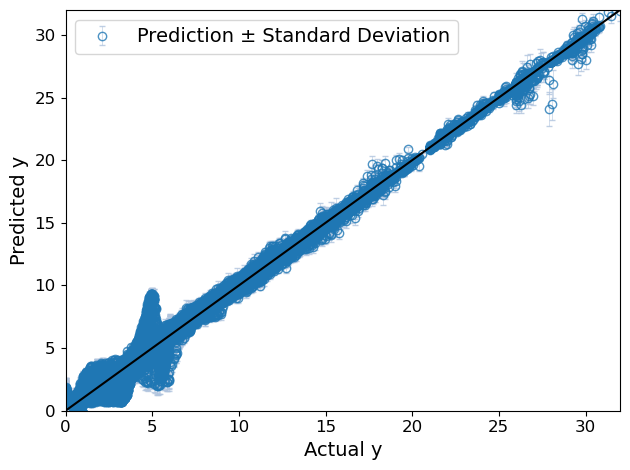

In [7]:
predictions = np.dstack((predictions_mean, predictions_std))
viz_prediction(test_Y, predictions, threshold=THRESHOLD)

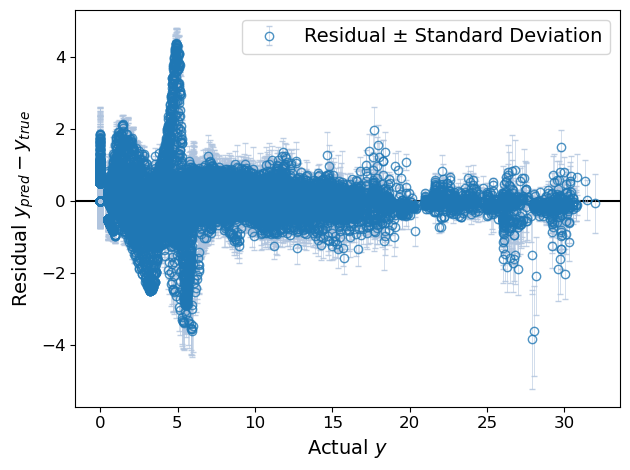

In [8]:
viz_residuals(test_Y, predictions, threshold=THRESHOLD)

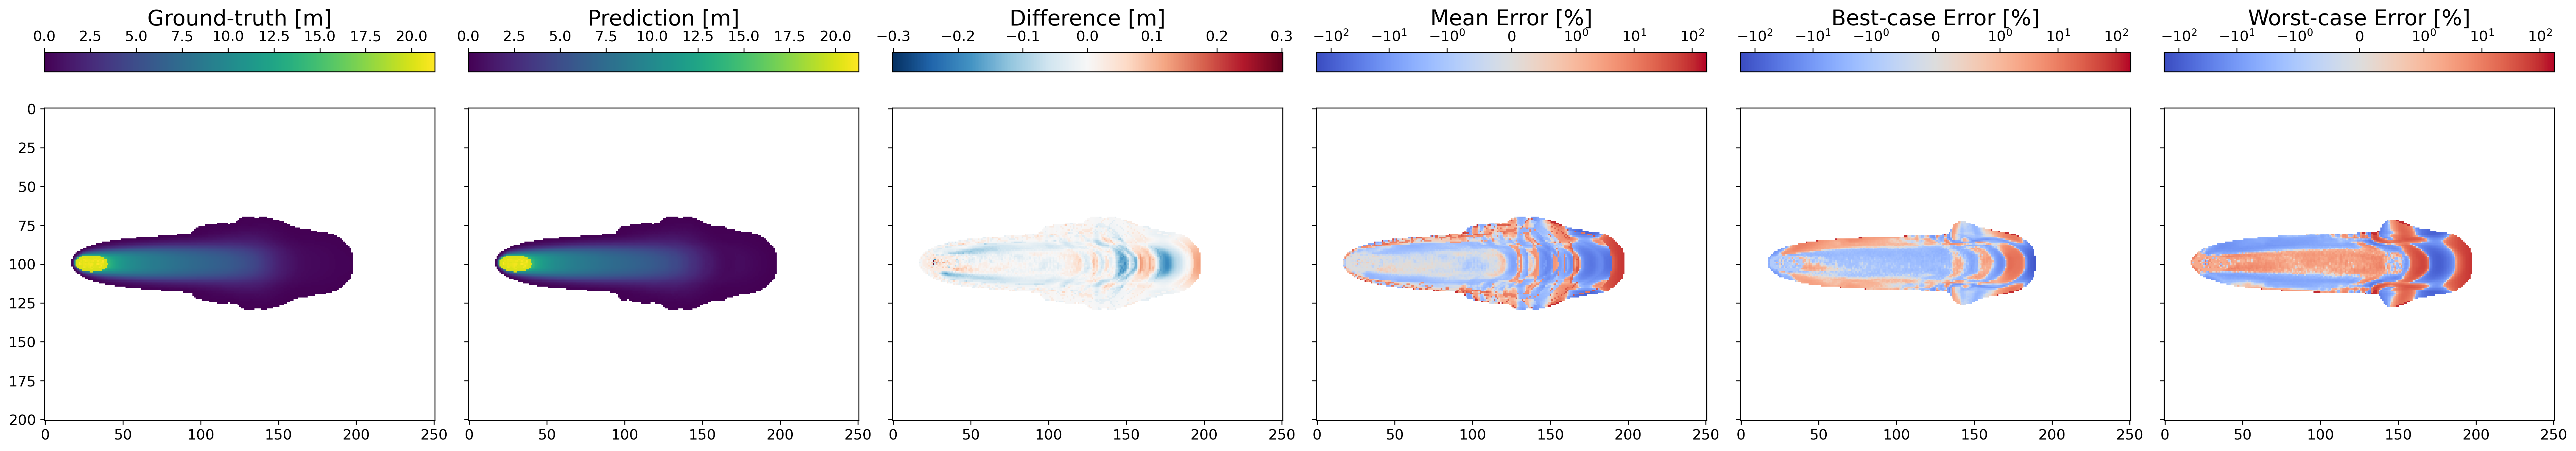

In [9]:
viz_all_2d_maps_in_one_plot(test_Y, predictions_mean, output_img_params, qoi="hmax", threshold=THRESHOLD)

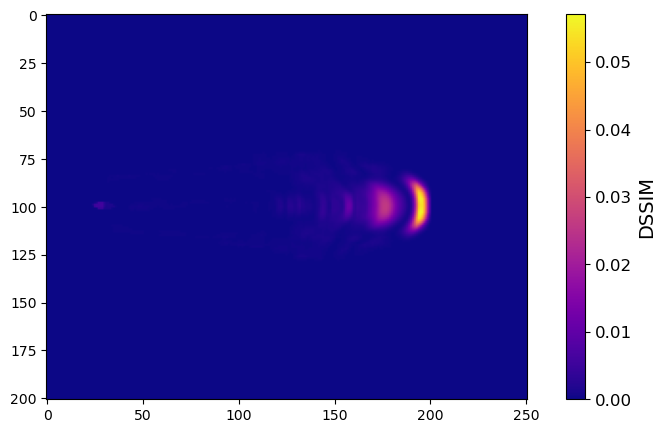

In [10]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(predictions_mean < THRESHOLD, 0.0, predictions_mean)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [11]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_mean)
predictions_lower = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_lower)
predictions_upper = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_upper)
predictions_std = np.where(predictions[:, :, 0] < THRESHOLD, 0, predictions_std)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


ppgasp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {ppgasp_results["dssim"]: .3f}')

Training time: 3.089 s
Inference time: 0.007 s
RMSE:  0.174
95% confidence interval coverage probability:  0.843
Quantile coverage error:  0.107
DSSIM:  0.002


### (2) BiGP (PPGaSP in GPytorch)

In [12]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = BiGP(device=device, kernel_type='matern_5_2')

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, num_epochs=100, lr=0.05, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

bigp_results = {
    "prediction_mean": mean,
    "prediction_std": std,
    "training_time": training_time,
    "infer_time": infer_time
}

training...:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/100, Loss: 1.729


training...:  10%|█         | 10/100 [00:48<08:02,  5.36s/it]

Epoch 10/100, Loss: 1.566


training...:  20%|██        | 20/100 [01:58<09:14,  6.93s/it]

Epoch 20/100, Loss: 1.412


training...:  30%|███       | 30/100 [03:06<07:52,  6.75s/it]

Epoch 30/100, Loss: 1.252


training...:  40%|████      | 40/100 [04:12<06:33,  6.55s/it]

Epoch 40/100, Loss: 1.092


training...:  50%|█████     | 50/100 [05:19<05:40,  6.81s/it]

Epoch 50/100, Loss: 0.949


training...:  60%|██████    | 60/100 [06:38<05:31,  8.29s/it]

Epoch 60/100, Loss: 0.844


training...:  70%|███████   | 70/100 [08:21<05:30, 11.01s/it]

Epoch 70/100, Loss: 0.781


training...:  80%|████████  | 80/100 [10:46<05:03, 15.16s/it]

Epoch 80/100, Loss: 0.759


training...:  90%|█████████ | 90/100 [13:45<03:04, 18.42s/it]

Epoch 90/100, Loss: 0.760


training...: 100%|██████████| 100/100 [17:12<00:00, 10.33s/it]


Training GPytorch takes 1032.765 s


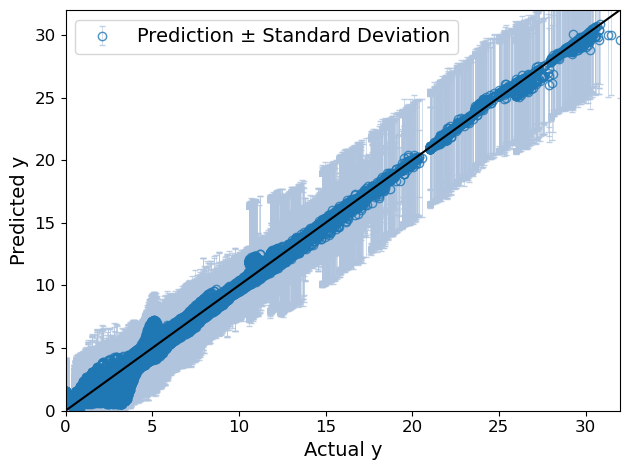

In [13]:
preds = np.dstack((mean, std))
viz_prediction(test_Y, preds, threshold=THRESHOLD)

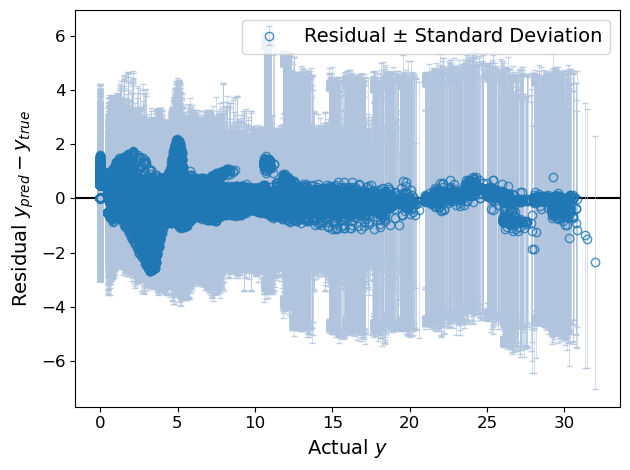

In [14]:
viz_residuals(test_Y, preds, threshold=THRESHOLD)

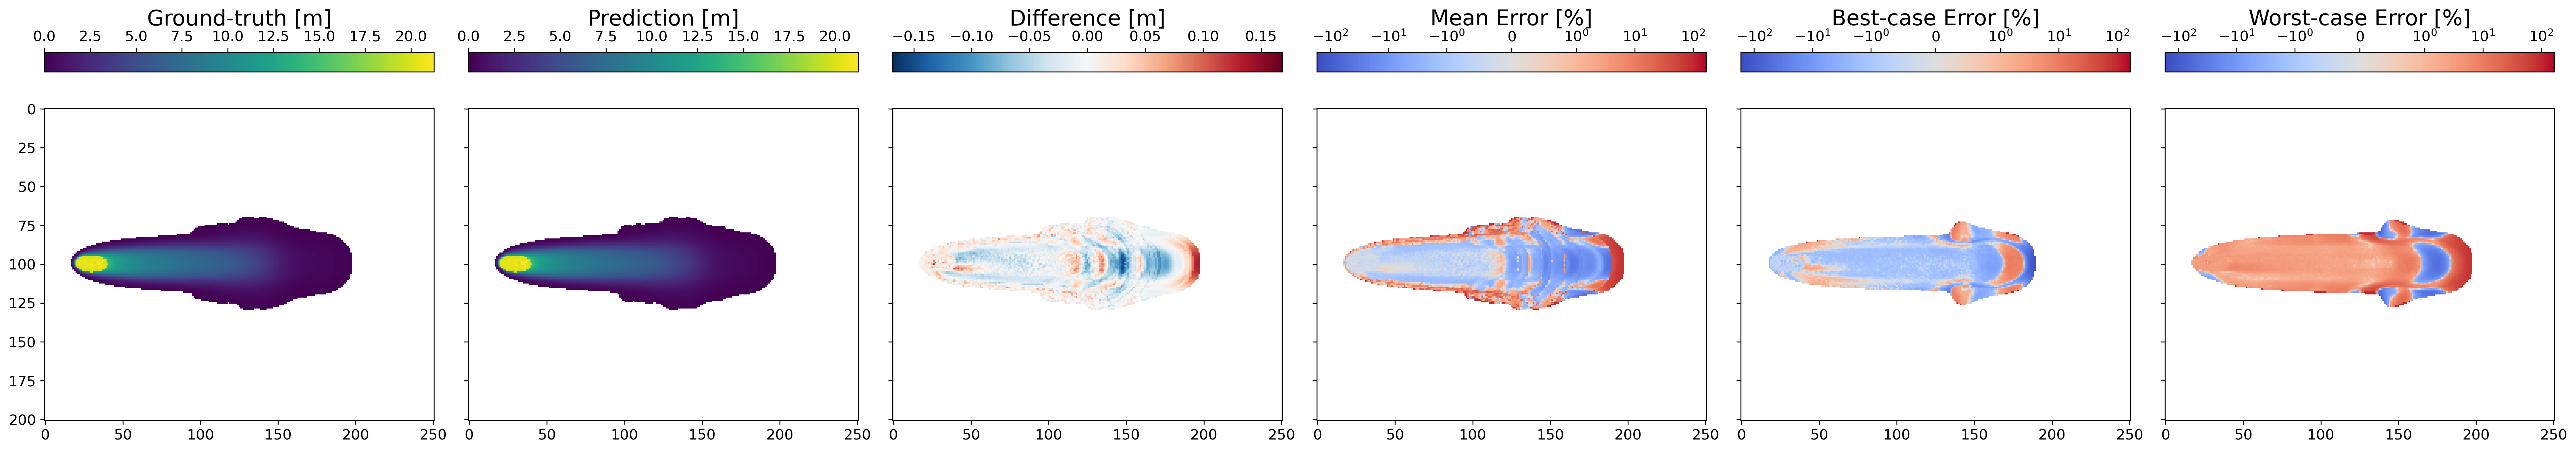

In [15]:
viz_all_2d_maps_in_one_plot(test_Y, mean, output_img_params, qoi="hmax", threshold=THRESHOLD)

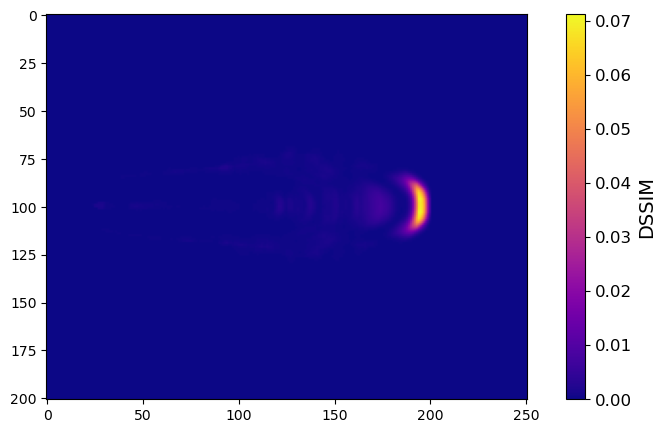

In [16]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(mean < THRESHOLD, 0.0, mean)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [17]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean < THRESHOLD, 0, mean)
predictions_lower = np.where(mean < THRESHOLD, 0, lower)
predictions_upper = np.where(mean < THRESHOLD, 0, upper)
predictions_std = np.where(mean < THRESHOLD, 0, std)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


bigp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {bigp_results["dssim"]: .3f}')

Training time: 1032.765 s
Inference time: 13.607 s
RMSE:  0.162
95% confidence interval coverage probability:  0.994
Quantile coverage error:  0.044
DSSIM:  0.002


#### (3) MTGP (LMC)

In [18]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = MultiTaskGP(base_inducing=64, min_rank=20, use_pca_init=True, device=device)

# Training
training_time = emulator.train(train_X=train_X, train_Y=train_Y, epochs=1000, lr=0.05)

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X=test_X)

INFO:gpytorch_emulator.svgp_lmc:Normalizing data...
INFO:gpytorch_emulator.svgp_lmc:Problem size: 3 inputs → 7878 outputs
INFO:gpytorch_emulator.svgp_lmc:Training samples: 100
INFO:gpytorch_emulator.svgp_lmc:Base parameters: base_inducing=64, min_rank=20
INFO:gpytorch_emulator.svgp_lmc:Calculated parameters: rank=20, num_inducing=88
INFO:gpytorch_emulator.svgp_lmc:Explained variance at rank 20: 0.996
INFO:gpytorch_emulator.svgp_lmc:Initializing inducing points with k-means clustering...
INFO:gpytorch_emulator.svgp_lmc:Initialized inducing points with shape: torch.Size([20, 88, 3])
INFO:gpytorch_emulator.svgp_lmc:Initializing LMC mixing matrix with PCA...
INFO:gpytorch_emulator.svgp_lmc:PCA explained variance ratio: [0.48277158 0.2445696  0.11165597 0.05821745 0.03329574 0.01723363
 0.01444267 0.00995678 0.00555926 0.00446939]...
INFO:gpytorch_emulator.svgp_lmc:Total explained variance: 0.9963
INFO:gpytorch_emulator.svgp_lmc:LMC coefficients initialized with shape: torch.Size([20, 7878]

Epoch   0, Loss: 61240.520, Beta: 0.0010, LR: 0.002500


training...:   3%|▎         | 28/1000 [00:01<01:03, 15.24it/s]

Epoch  25, Loss: 12272.233, Beta: 0.0010, LR: 0.049995


training...:   5%|▌         | 54/1000 [00:03<01:02, 15.16it/s]

Epoch  50, Loss: 917.974, Beta: 0.0077, LR: 0.049877


training...:   8%|▊         | 78/1000 [00:05<01:11, 12.94it/s]

Epoch  75, Loss: -1621.075, Beta: 0.0240, LR: 0.049598


training...:  10%|█         | 104/1000 [00:07<00:57, 15.46it/s]

Epoch 100, Loss: -4455.677, Beta: 0.0768, LR: 0.049162
  Avg lengthscale: 2.737, Avg outputscale: 0.388


training...:  13%|█▎        | 128/1000 [00:08<00:58, 14.80it/s]

Epoch 125, Loss: -6412.577, Beta: 0.2235, LR: 0.048570


training...:  15%|█▌        | 154/1000 [00:10<00:54, 15.63it/s]

Epoch 150, Loss: -7413.588, Beta: 0.5005, LR: 0.047828


training...:  18%|█▊        | 176/1000 [00:11<00:59, 13.74it/s]

Epoch 175, Loss: -7816.476, Beta: 0.7775, LR: 0.046938


training...:  20%|██        | 202/1000 [00:14<01:41,  7.86it/s]

Epoch 200, Loss: -7993.412, Beta: 0.9242, LR: 0.045908
  Avg lengthscale: 2.714, Avg outputscale: 0.425


training...:  23%|██▎       | 227/1000 [00:16<01:02, 12.34it/s]

Epoch 225, Loss: -8193.977, Beta: 0.9770, LR: 0.044744


training...:  25%|██▌       | 253/1000 [00:19<01:15,  9.95it/s]

Epoch 250, Loss: -8367.146, Beta: 1.0000, LR: 0.043453


training...:  28%|██▊       | 277/1000 [00:21<01:07, 10.64it/s]

Epoch 275, Loss: -8630.003, Beta: 1.0000, LR: 0.042043


training...:  30%|███       | 302/1000 [00:25<01:49,  6.38it/s]

Epoch 300, Loss: -8833.388, Beta: 1.0000, LR: 0.040525
  Avg lengthscale: 2.752, Avg outputscale: 0.442


training...:  33%|███▎      | 328/1000 [00:28<00:49, 13.69it/s]

Epoch 325, Loss: -9268.685, Beta: 1.0000, LR: 0.038906


training...:  35%|███▌      | 352/1000 [00:30<00:49, 13.00it/s]

Epoch 350, Loss: -8823.594, Beta: 1.0000, LR: 0.037198


training...:  38%|███▊      | 378/1000 [00:32<00:43, 14.41it/s]

Epoch 375, Loss: -9482.535, Beta: 1.0000, LR: 0.035412


training...:  40%|████      | 404/1000 [00:33<00:35, 16.61it/s]

Epoch 400, Loss: -9423.121, Beta: 1.0000, LR: 0.033559
  Avg lengthscale: 2.766, Avg outputscale: 0.432


training...:  43%|████▎     | 428/1000 [00:35<00:37, 15.30it/s]

Epoch 425, Loss: -9706.649, Beta: 1.0000, LR: 0.031651


training...:  45%|████▌     | 454/1000 [00:37<00:32, 16.84it/s]

Epoch 450, Loss: -9214.260, Beta: 1.0000, LR: 0.029700


training...:  48%|████▊     | 478/1000 [00:38<00:31, 16.37it/s]

Epoch 475, Loss: -9986.603, Beta: 1.0000, LR: 0.027719


training...:  50%|█████     | 504/1000 [00:40<00:31, 15.96it/s]

Epoch 500, Loss: -9949.240, Beta: 1.0000, LR: 0.025721
  Avg lengthscale: 2.792, Avg outputscale: 0.446


training...:  53%|█████▎    | 528/1000 [00:41<00:27, 17.17it/s]

Epoch 525, Loss: -10152.522, Beta: 1.0000, LR: 0.023718


training...:  55%|█████▌    | 554/1000 [00:43<00:25, 17.56it/s]

Epoch 550, Loss: -9594.533, Beta: 1.0000, LR: 0.021724


training...:  58%|█████▊    | 578/1000 [00:44<00:25, 16.37it/s]

Epoch 575, Loss: -10217.866, Beta: 1.0000, LR: 0.019750


training...:  60%|██████    | 604/1000 [00:46<00:24, 16.45it/s]

Epoch 600, Loss: -10484.920, Beta: 1.0000, LR: 0.017810
  Avg lengthscale: 2.794, Avg outputscale: 0.456


training...:  63%|██████▎   | 628/1000 [00:47<00:20, 18.36it/s]

Epoch 625, Loss: -10654.521, Beta: 1.0000, LR: 0.015916


training...:  65%|██████▌   | 654/1000 [00:48<00:19, 17.91it/s]

Epoch 650, Loss: -10658.206, Beta: 1.0000, LR: 0.014081


training...:  68%|██████▊   | 678/1000 [00:50<00:17, 18.20it/s]

Epoch 675, Loss: -10759.262, Beta: 1.0000, LR: 0.012315


training...:  70%|███████   | 704/1000 [00:51<00:16, 18.24it/s]

Epoch 700, Loss: -10787.791, Beta: 1.0000, LR: 0.010631
  Avg lengthscale: 2.794, Avg outputscale: 0.479


training...:  73%|███████▎  | 728/1000 [00:52<00:14, 18.76it/s]

Epoch 725, Loss: -10842.617, Beta: 1.0000, LR: 0.009040


training...:  75%|███████▌  | 754/1000 [00:54<00:13, 18.73it/s]

Epoch 750, Loss: -10849.345, Beta: 1.0000, LR: 0.007550


training...:  78%|███████▊  | 778/1000 [00:55<00:11, 18.70it/s]

Epoch 775, Loss: -10902.960, Beta: 1.0000, LR: 0.006173


training...:  80%|████████  | 804/1000 [00:57<00:12, 15.84it/s]

Epoch 800, Loss: -10932.834, Beta: 1.0000, LR: 0.004917
  Avg lengthscale: 2.797, Avg outputscale: 0.501


training...:  83%|████████▎ | 828/1000 [00:58<00:10, 17.00it/s]

Epoch 825, Loss: -10968.759, Beta: 1.0000, LR: 0.003789


training...:  85%|████████▌ | 854/1000 [01:00<00:08, 16.28it/s]

Epoch 850, Loss: -10993.143, Beta: 1.0000, LR: 0.002798


training...:  88%|████████▊ | 878/1000 [01:01<00:07, 15.95it/s]

Epoch 875, Loss: -11019.395, Beta: 1.0000, LR: 0.001949


training...:  90%|█████████ | 902/1000 [01:03<00:06, 15.54it/s]

Epoch 900, Loss: -11033.168, Beta: 1.0000, LR: 0.001248
  Avg lengthscale: 2.798, Avg outputscale: 0.521


training...:  93%|█████████▎| 928/1000 [01:05<00:04, 15.89it/s]

Epoch 925, Loss: -11070.967, Beta: 1.0000, LR: 0.000700


training...:  95%|█████████▌| 952/1000 [01:06<00:03, 15.54it/s]

Epoch 950, Loss: -11091.380, Beta: 1.0000, LR: 0.000308


training...:  98%|█████████▊| 978/1000 [01:08<00:01, 16.59it/s]

Epoch 975, Loss: -11103.775, Beta: 1.0000, LR: 0.000074


training...: 100%|██████████| 1000/1000 [01:09<00:00, 14.35it/s]
INFO:gpytorch_emulator.svgp_lmc:Training time: 69.711 seconds
INFO:gpytorch_emulator.svgp_lmc:Starting evaluation with uncertainty quantification...
INFO:gpytorch_emulator.svgp_lmc:Inference time: 0.005 seconds


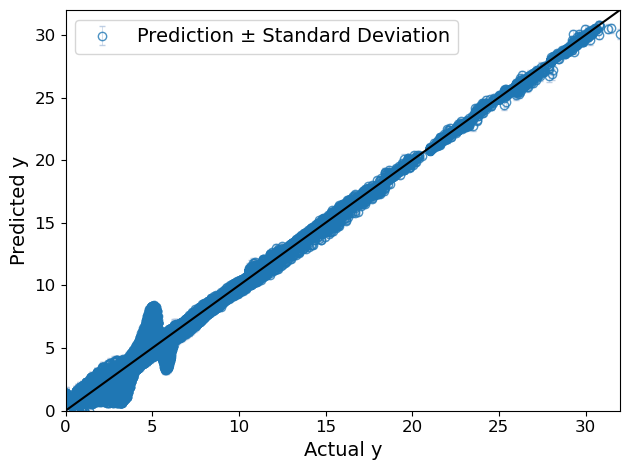

In [19]:
predictions = np.dstack((mean, std))
viz_prediction(test_Y, predictions, threshold=THRESHOLD)

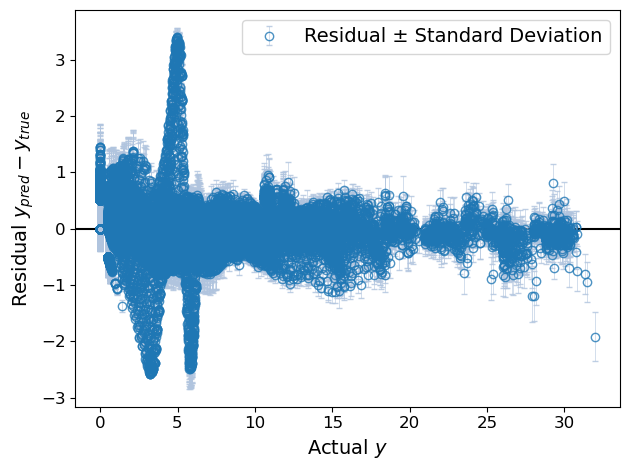

In [20]:
viz_residuals(test_Y, predictions, threshold=THRESHOLD)

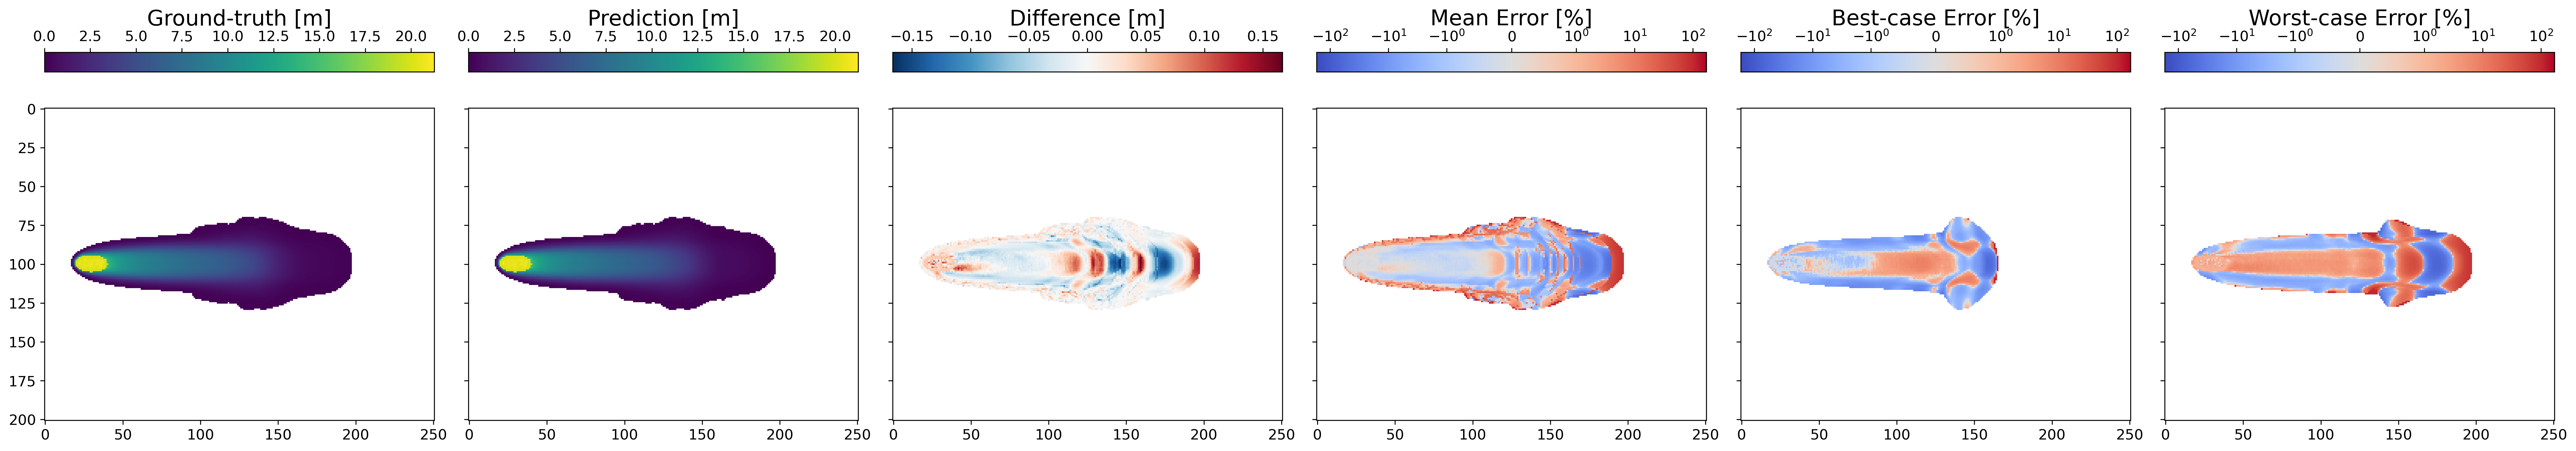

In [21]:
viz_all_2d_maps_in_one_plot(test_Y, mean, output_img_params, qoi="hmax", threshold=THRESHOLD)

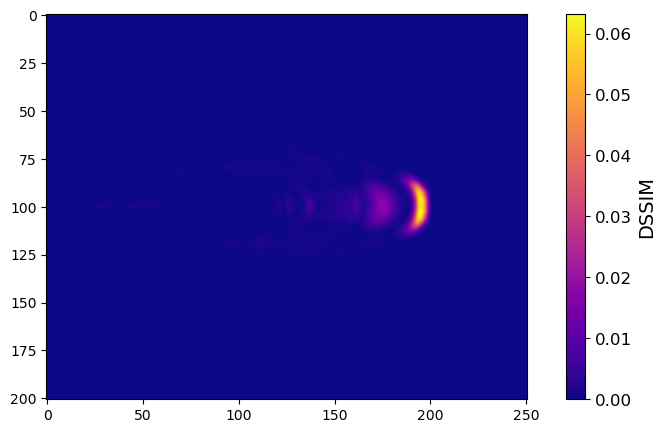

In [22]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(mean < THRESHOLD, 0.0, mean)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [23]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean < THRESHOLD, 0, mean)
predictions_lower = np.where(mean < THRESHOLD, 0, lower)
predictions_upper = np.where(mean < THRESHOLD, 0, upper)
predictions_std = np.where(mean < THRESHOLD, 0, std)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


lmc_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {lmc_results["dssim"]: .3f}')

Training time: 69.711 s
Inference time: 0.005 s
RMSE:  0.153
95% confidence interval coverage probability:  0.896
Quantile coverage error:  0.054
DSSIM:  0.001


### PCA + GP-variants
#### (1) PCA-PPGaSP

In [24]:
# Model setup
input_reducer  = None
output_reducer = OutputDimReducer(LinearPCA(n_components=20))
emulator = PCAPPGaSP(
        ndim=int(reduced_dim(input_reducer, train_X)),
        input_dim_reducer=input_reducer,
        output_dim_reducer=output_reducer,
    )
# Training
training_time = emulator.train(train_X, train_Y)

# Prediction
test_Y_scaled = emulator.output_scaler.transform(test_Y)
test_Y_scaled_reduced = emulator.output_dim_reducer.transform(test_Y_scaled)
predictions_latent, predictions_mean_original, infer_time, predictions_uncertainty = emulator.predict(test_X, uncertainty_reconstruction=True)

Explained variance when number of components is 20: 0.9962574035764927.
The upper bounds of the range parameters are 90.83204 90.65336 91.39353 
The initial values of range parameters are 1.816641 1.813067 1.827871 
Start of the optimization  1  : 
The number of iterations is  12 
 The value of the  marginal posterior  function is  -7085.377 
 Optimized range parameters are 0.8912541 1.555825 2.667437 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
The initial values of range parameters are 0.9567502 0.9548681 0.9626645 
Start of the optimization  2  : 
The number of iterations is  12 
 The value of the  marginal posterior  function is  -7085.377 
 Optimized range parameters are 0.8912541 1.555825 2.667437 
 Optimized nugget parameter is 0 
 Convergence:  TRUE 
Processing output PCA takes 0.082 s
Training PCAPPGaSP takes 0.156 s
Total training PCAPPGaSP takes 0.238 s
Inference PCAPPGaSP takes 0.002 s
Post-process PCAPPGaSP takes 0.004 s
Total inference PCAPPGaSP takes 0.006 s


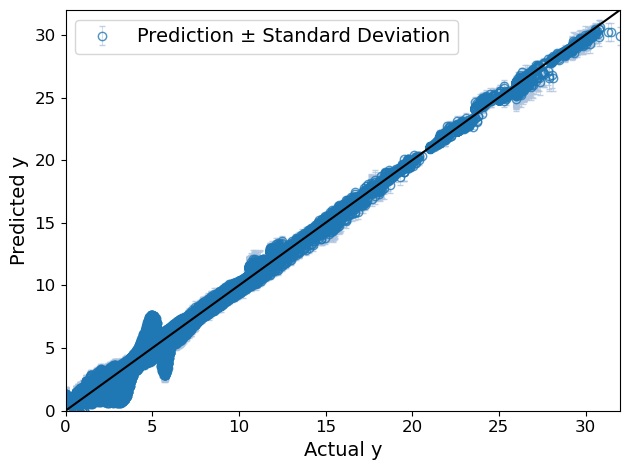

In [25]:
preds = np.dstack((predictions_mean_original, predictions_uncertainty[:, :, 2]))
viz_prediction(test_Y, preds, threshold=THRESHOLD)

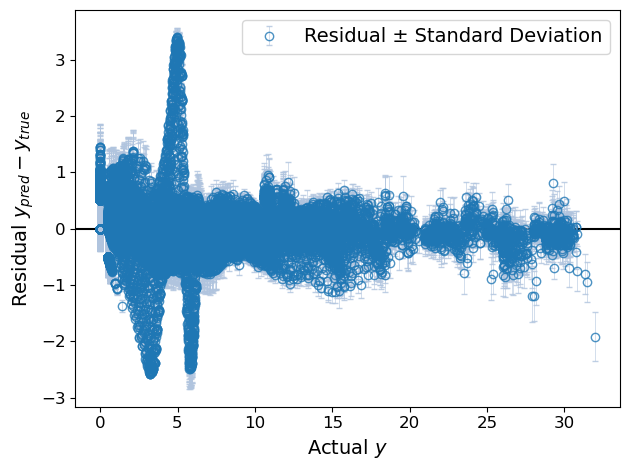

In [26]:
viz_residuals(test_Y, predictions, threshold=THRESHOLD)

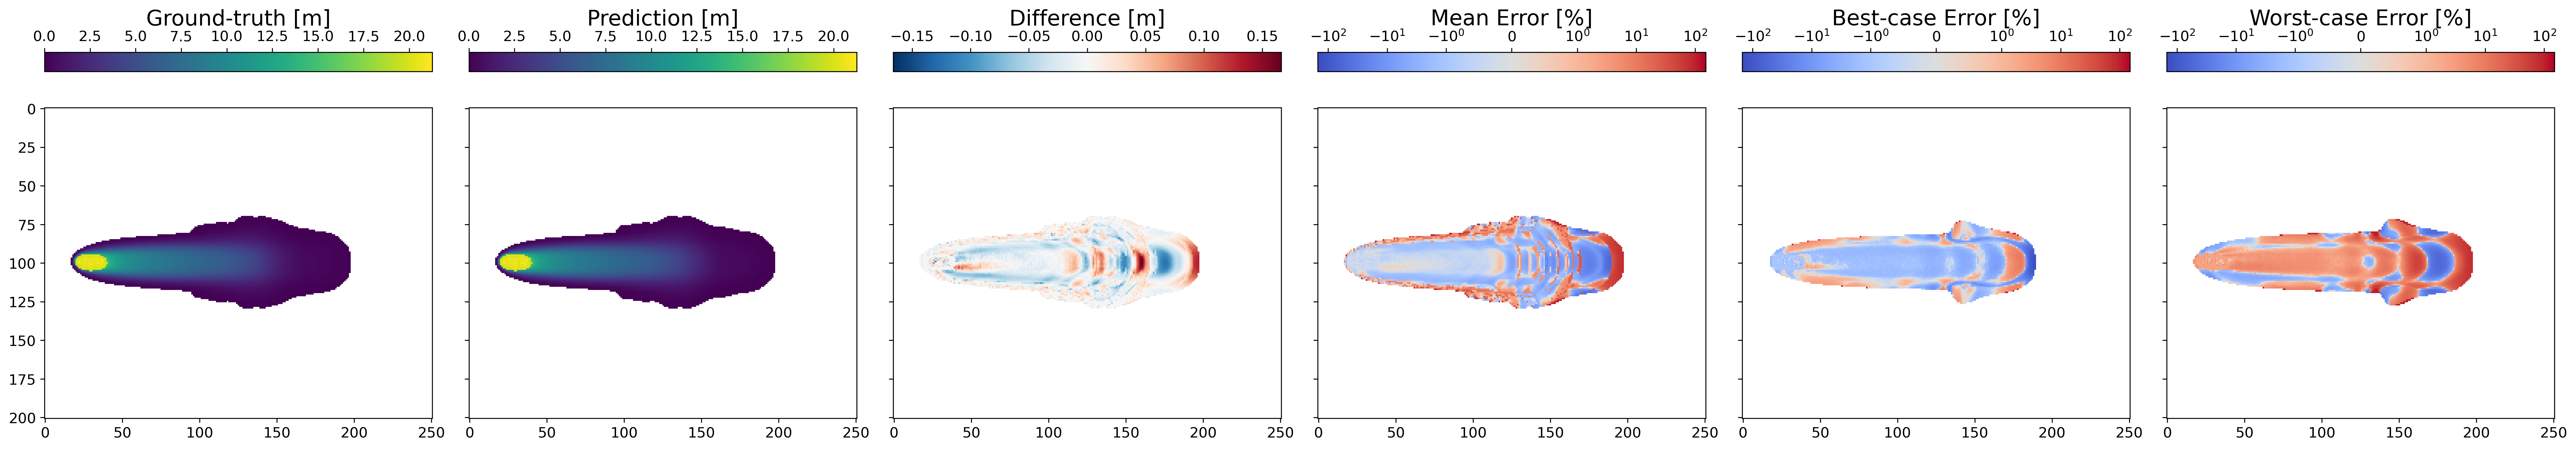

In [27]:
viz_all_2d_maps_in_one_plot(test_Y, predictions_mean_original, output_img_params, qoi="hmax", threshold=THRESHOLD)

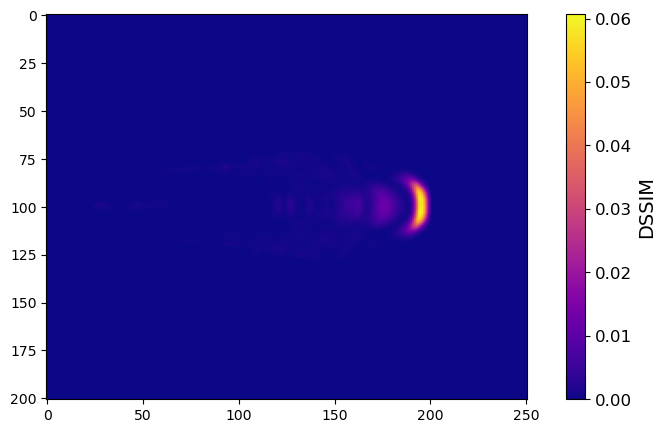

In [28]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(predictions_mean_original < THRESHOLD, 0.0, predictions_mean_original)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [29]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(predictions_mean_original < THRESHOLD, 0, predictions_mean_original)
predictions_lower = np.where(predictions_mean_original < THRESHOLD, 0, predictions_uncertainty[:, :, 0])
predictions_upper = np.where(predictions_mean_original < THRESHOLD, 0, predictions_uncertainty[:, :, 1])
predictions_std = np.where(predictions_mean_original < THRESHOLD, 0, predictions_uncertainty[:, :, 2])

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


pca_ppgasp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {pca_ppgasp_results["dssim"]: .3f}')

Training time: 0.238 s
Inference time: 0.006 s
RMSE:  0.155
95% confidence interval coverage probability:  0.888
Quantile coverage error:  0.062
DSSIM:  0.001


#### (2) PCA-BiGP

In [30]:
# Model setup
device = "cuda" if torch.cuda.is_available() else "cpu"
output_reducer = OutputDimReducer(LinearPCA(n_components=20))
emulator = PCA_BiGP(output_reducer, device=device, kernel_type='matern_5_2')

# Preprocessing (dimenionality reduction)
train_X_scaled, train_Y_scaled_reduced, test_X_scaled, test_Y_scaled_reduced = emulator.preprocess_dim_reduction(train_X, train_Y, test_X, test_Y)

# Training
training_time = emulator.train(train_X_scaled, train_Y_scaled_reduced, num_epochs=1000, lr=0.01, optim="adamw")

# Prediction
mean, std, lower, upper, infer_time = emulator.predict(test_X_scaled)    

# Postprocessing (Revert back to original space)
mean_original, std_original, lower_CI, upper_CI = emulator.postprocess_invert_back(mean, std)

Explained variance when number of components is 20: 0.9962574035764926.
Reduced output dimension to 20.


training...:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0/1000, Loss: 1.865


training...:   2%|▏         | 18/1000 [00:00<00:24, 40.47it/s]

Epoch 10/1000, Loss: 1.840


training...:   3%|▎         | 28/1000 [00:00<00:22, 42.29it/s]

Epoch 20/1000, Loss: 1.812


training...:   4%|▍         | 38/1000 [00:00<00:22, 43.07it/s]

Epoch 30/1000, Loss: 1.789


training...:   5%|▍         | 48/1000 [00:01<00:21, 43.64it/s]

Epoch 40/1000, Loss: 1.771


training...:   6%|▌         | 58/1000 [00:01<00:22, 41.25it/s]

Epoch 50/1000, Loss: 1.754


training...:   7%|▋         | 67/1000 [00:01<00:25, 36.87it/s]

Epoch 60/1000, Loss: 1.740


training...:   8%|▊         | 75/1000 [00:01<00:24, 37.52it/s]

Epoch 70/1000, Loss: 1.726


training...:   9%|▊         | 87/1000 [00:02<00:24, 36.61it/s]

Epoch 80/1000, Loss: 1.720


training...:  10%|▉         | 95/1000 [00:02<00:24, 36.24it/s]

Epoch 90/1000, Loss: 1.701


training...:  10%|█         | 105/1000 [00:02<00:22, 39.30it/s]

Epoch 100/1000, Loss: 1.691


training...:  12%|█▏        | 119/1000 [00:03<00:21, 40.40it/s]

Epoch 110/1000, Loss: 1.683


training...:  13%|█▎        | 128/1000 [00:03<00:22, 39.58it/s]

Epoch 120/1000, Loss: 1.661


training...:  14%|█▎        | 137/1000 [00:03<00:21, 39.99it/s]

Epoch 130/1000, Loss: 1.659


training...:  14%|█▍        | 145/1000 [00:03<00:21, 39.32it/s]

Epoch 140/1000, Loss: 1.654


training...:  16%|█▌        | 158/1000 [00:04<00:21, 39.39it/s]

Epoch 150/1000, Loss: 1.646


training...:  17%|█▋        | 167/1000 [00:04<00:20, 39.68it/s]

Epoch 160/1000, Loss: 1.634


training...:  18%|█▊        | 176/1000 [00:04<00:20, 39.39it/s]

Epoch 170/1000, Loss: 1.622


training...:  18%|█▊        | 185/1000 [00:04<00:20, 39.66it/s]

Epoch 180/1000, Loss: 1.608


training...:  19%|█▉        | 193/1000 [00:05<00:27, 29.62it/s]

Epoch 190/1000, Loss: 1.598


training...:  20%|██        | 205/1000 [00:05<00:23, 33.63it/s]

Epoch 200/1000, Loss: 1.583


training...:  22%|██▏       | 218/1000 [00:05<00:20, 37.73it/s]

Epoch 210/1000, Loss: 1.580


training...:  23%|██▎       | 228/1000 [00:05<00:19, 40.04it/s]

Epoch 220/1000, Loss: 1.572


training...:  24%|██▍       | 238/1000 [00:06<00:18, 40.97it/s]

Epoch 230/1000, Loss: 1.552


training...:  25%|██▍       | 248/1000 [00:06<00:18, 40.08it/s]

Epoch 240/1000, Loss: 1.547


training...:  26%|██▌       | 257/1000 [00:06<00:18, 39.26it/s]

Epoch 250/1000, Loss: 1.535


training...:  26%|██▋       | 265/1000 [00:06<00:19, 37.00it/s]

Epoch 260/1000, Loss: 1.522


training...:  28%|██▊       | 278/1000 [00:07<00:18, 38.77it/s]

Epoch 270/1000, Loss: 1.513


training...:  29%|██▉       | 288/1000 [00:07<00:17, 40.86it/s]

Epoch 280/1000, Loss: 1.493


training...:  30%|██▉       | 298/1000 [00:07<00:17, 40.49it/s]

Epoch 290/1000, Loss: 1.477


training...:  31%|███       | 307/1000 [00:07<00:17, 39.63it/s]

Epoch 300/1000, Loss: 1.475


training...:  32%|███▏      | 317/1000 [00:08<00:17, 40.12it/s]

Epoch 310/1000, Loss: 1.467


training...:  33%|███▎      | 326/1000 [00:08<00:18, 35.62it/s]

Epoch 320/1000, Loss: 1.450


training...:  34%|███▍      | 338/1000 [00:08<00:17, 36.93it/s]

Epoch 330/1000, Loss: 1.433


training...:  35%|███▍      | 346/1000 [00:09<00:19, 34.17it/s]

Epoch 340/1000, Loss: 1.414


training...:  36%|███▌      | 355/1000 [00:09<00:17, 36.49it/s]

Epoch 350/1000, Loss: 1.406


training...:  37%|███▋      | 367/1000 [00:09<00:17, 35.44it/s]

Epoch 360/1000, Loss: 1.374


training...:  38%|███▊      | 375/1000 [00:09<00:19, 32.89it/s]

Epoch 370/1000, Loss: 1.387


training...:  39%|███▊      | 387/1000 [00:10<00:17, 35.73it/s]

Epoch 380/1000, Loss: 1.364


training...:  40%|███▉      | 396/1000 [00:10<00:15, 38.37it/s]

Epoch 390/1000, Loss: 1.380


training...:  41%|████      | 408/1000 [00:10<00:15, 37.91it/s]

Epoch 400/1000, Loss: 1.378


training...:  42%|████▏     | 417/1000 [00:10<00:15, 38.64it/s]

Epoch 410/1000, Loss: 1.438


training...:  43%|████▎     | 426/1000 [00:11<00:14, 38.43it/s]

Epoch 420/1000, Loss: 1.426


training...:  43%|████▎     | 434/1000 [00:11<00:15, 36.57it/s]

Epoch 430/1000, Loss: 1.402


training...:  45%|████▍     | 448/1000 [00:11<00:14, 38.22it/s]

Epoch 440/1000, Loss: 1.361


training...:  46%|████▌     | 457/1000 [00:11<00:14, 38.39it/s]

Epoch 450/1000, Loss: 1.356


training...:  47%|████▋     | 467/1000 [00:12<00:13, 39.94it/s]

Epoch 460/1000, Loss: 1.361


training...:  47%|████▋     | 472/1000 [00:12<00:13, 40.22it/s]

Epoch 470/1000, Loss: 1.436


training...:  48%|████▊     | 485/1000 [00:12<00:14, 34.96it/s]

Epoch 480/1000, Loss: 1.356


training...:  50%|████▉     | 497/1000 [00:13<00:13, 36.89it/s]

Epoch 490/1000, Loss: 1.350


training...:  50%|█████     | 505/1000 [00:13<00:13, 36.69it/s]

Epoch 500/1000, Loss: 1.433


training...:  51%|█████▏    | 513/1000 [00:13<00:13, 37.06it/s]

Epoch 510/1000, Loss: 1.462


training...:  52%|█████▎    | 525/1000 [00:13<00:13, 35.29it/s]

Epoch 520/1000, Loss: 1.356


training...:  54%|█████▍    | 539/1000 [00:14<00:11, 39.33it/s]

Epoch 530/1000, Loss: 1.306


training...:  54%|█████▍    | 544/1000 [00:14<00:11, 40.17it/s]

Epoch 540/1000, Loss: 1.307


training...:  55%|█████▌    | 554/1000 [00:14<00:10, 40.97it/s]

Epoch 550/1000, Loss: 1.313


training...:  57%|█████▋    | 568/1000 [00:14<00:11, 39.09it/s]

Epoch 560/1000, Loss: 1.377


training...:  58%|█████▊    | 576/1000 [00:15<00:11, 38.44it/s]

Epoch 570/1000, Loss: 1.347


training...:  58%|█████▊    | 585/1000 [00:15<00:10, 38.92it/s]

Epoch 580/1000, Loss: 1.433


training...:  60%|█████▉    | 595/1000 [00:15<00:10, 40.27it/s]

Epoch 590/1000, Loss: 1.356


training...:  60%|██████    | 605/1000 [00:15<00:09, 40.12it/s]

Epoch 600/1000, Loss: 1.427


training...:  62%|██████▏   | 615/1000 [00:16<00:09, 40.52it/s]

Epoch 610/1000, Loss: 1.425


training...:  62%|██████▎   | 625/1000 [00:16<00:09, 40.75it/s]

Epoch 620/1000, Loss: 1.321


training...:  63%|██████▎   | 634/1000 [00:16<00:09, 38.22it/s]

Epoch 630/1000, Loss: 1.320


training...:  65%|██████▍   | 646/1000 [00:16<00:09, 35.67it/s]

Epoch 640/1000, Loss: 1.337


training...:  65%|██████▌   | 654/1000 [00:17<00:09, 36.07it/s]

Epoch 650/1000, Loss: 1.328


training...:  66%|██████▋   | 664/1000 [00:17<00:08, 38.43it/s]

Epoch 660/1000, Loss: 1.315


training...:  68%|██████▊   | 678/1000 [00:17<00:08, 39.49it/s]

Epoch 670/1000, Loss: 1.346


training...:  69%|██████▉   | 688/1000 [00:18<00:07, 41.34it/s]

Epoch 680/1000, Loss: 1.357


training...:  69%|██████▉   | 693/1000 [00:18<00:07, 41.91it/s]

Epoch 690/1000, Loss: 1.415


training...:  71%|███████   | 707/1000 [00:18<00:07, 38.62it/s]

Epoch 700/1000, Loss: 1.461


training...:  72%|███████▏  | 716/1000 [00:18<00:07, 38.67it/s]

Epoch 710/1000, Loss: 1.316


training...:  73%|███████▎  | 726/1000 [00:19<00:06, 40.73it/s]

Epoch 720/1000, Loss: 1.354


training...:  74%|███████▎  | 736/1000 [00:19<00:06, 40.69it/s]

Epoch 730/1000, Loss: 1.326


training...:  74%|███████▍  | 741/1000 [00:19<00:06, 40.91it/s]

Epoch 740/1000, Loss: 1.341


training...:  76%|███████▌  | 758/1000 [00:19<00:06, 36.09it/s]

Epoch 750/1000, Loss: 1.296


training...:  77%|███████▋  | 766/1000 [00:20<00:06, 37.29it/s]

Epoch 760/1000, Loss: 1.319


training...:  77%|███████▋  | 774/1000 [00:20<00:06, 36.20it/s]

Epoch 770/1000, Loss: 1.426


training...:  79%|███████▊  | 786/1000 [00:20<00:05, 36.36it/s]

Epoch 780/1000, Loss: 1.459


training...:  80%|███████▉  | 798/1000 [00:20<00:05, 37.48it/s]

Epoch 790/1000, Loss: 1.363


training...:  81%|████████  | 807/1000 [00:21<00:05, 38.53it/s]

Epoch 800/1000, Loss: 1.307


training...:  82%|████████▏ | 816/1000 [00:21<00:04, 40.25it/s]

Epoch 810/1000, Loss: 1.560


training...:  83%|████████▎ | 826/1000 [00:21<00:04, 41.85it/s]

Epoch 820/1000, Loss: 1.325


training...:  84%|████████▎ | 836/1000 [00:21<00:03, 42.63it/s]

Epoch 830/1000, Loss: 1.341


training...:  85%|████████▍ | 846/1000 [00:22<00:03, 39.85it/s]

Epoch 840/1000, Loss: 1.320


training...:  86%|████████▌ | 855/1000 [00:22<00:03, 38.95it/s]

Epoch 850/1000, Loss: 1.346


training...:  87%|████████▋ | 867/1000 [00:22<00:03, 38.67it/s]

Epoch 860/1000, Loss: 1.486


training...:  88%|████████▊ | 877/1000 [00:22<00:03, 40.59it/s]

Epoch 870/1000, Loss: 1.519


training...:  88%|████████▊ | 882/1000 [00:23<00:02, 40.13it/s]

Epoch 880/1000, Loss: 1.437


training...:  90%|████████▉ | 895/1000 [00:23<00:02, 36.20it/s]

Epoch 890/1000, Loss: 1.357


training...:  91%|█████████ | 907/1000 [00:23<00:02, 38.34it/s]

Epoch 900/1000, Loss: 1.561


training...:  92%|█████████▏| 917/1000 [00:24<00:02, 39.76it/s]

Epoch 910/1000, Loss: 1.539


training...:  93%|█████████▎| 927/1000 [00:24<00:01, 41.74it/s]

Epoch 920/1000, Loss: 1.302


training...:  94%|█████████▎| 937/1000 [00:24<00:01, 41.67it/s]

Epoch 930/1000, Loss: 1.301


training...:  95%|█████████▍| 947/1000 [00:24<00:01, 39.86it/s]

Epoch 940/1000, Loss: 1.422


training...:  96%|█████████▌| 956/1000 [00:24<00:01, 39.20it/s]

Epoch 950/1000, Loss: 1.380


training...:  97%|█████████▋| 966/1000 [00:25<00:00, 40.37it/s]

Epoch 960/1000, Loss: 1.487


training...:  98%|█████████▊| 976/1000 [00:25<00:00, 41.04it/s]

Epoch 970/1000, Loss: 1.411


training...:  99%|█████████▊| 986/1000 [00:25<00:00, 41.36it/s]

Epoch 980/1000, Loss: 1.359


training...: 100%|█████████▉| 996/1000 [00:25<00:00, 41.60it/s]

Epoch 990/1000, Loss: 1.294


training...: 100%|██████████| 1000/1000 [00:26<00:00, 38.42it/s]


Training GPytorch takes 26.032 s
Inverse transform back to original output dimension: 7878.


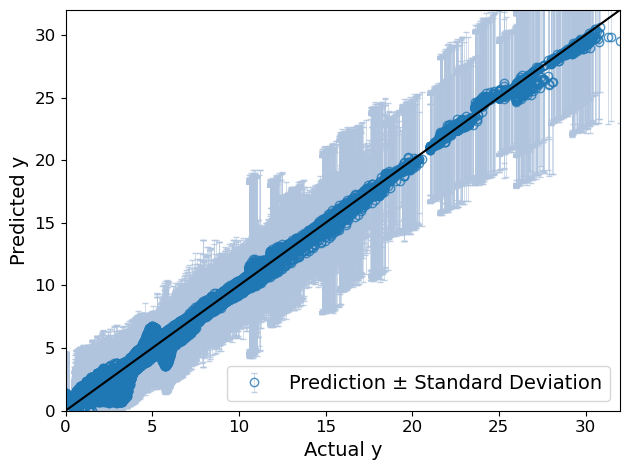

In [31]:
predictions = np.dstack((mean_original, std_original))
viz_prediction(test_Y, predictions, threshold=THRESHOLD)

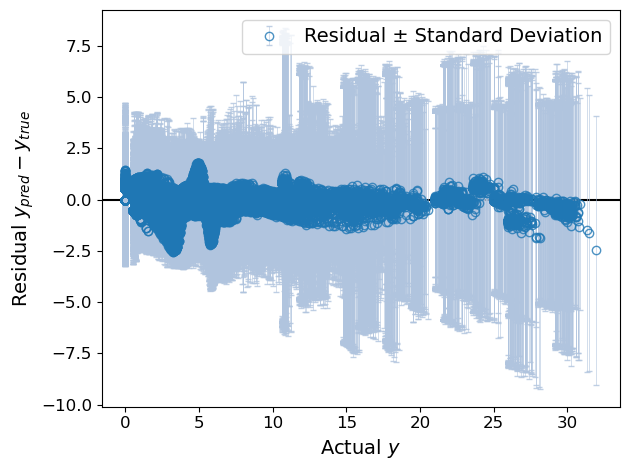

In [32]:
viz_residuals(test_Y, predictions, threshold=THRESHOLD)

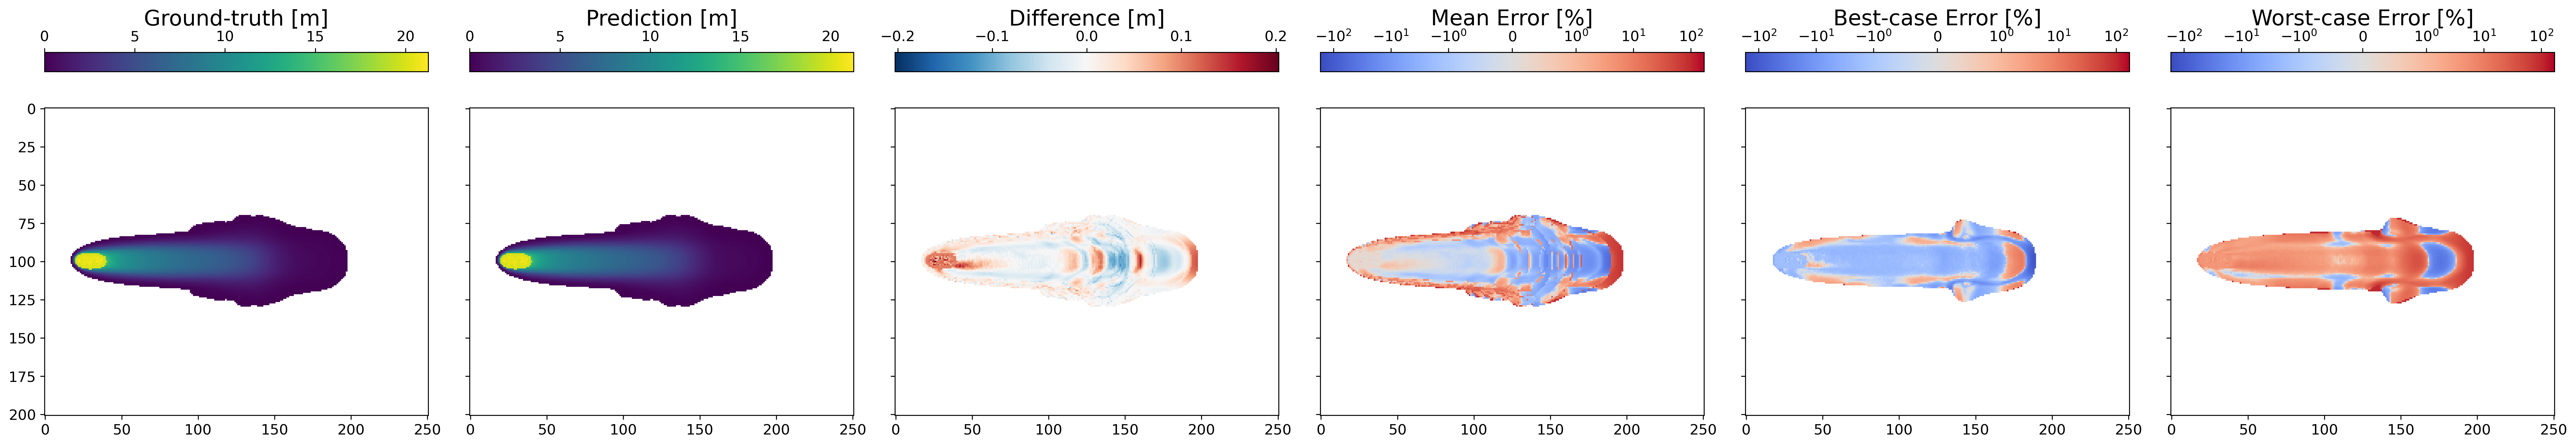

In [33]:
viz_all_2d_maps_in_one_plot(test_Y, mean_original, output_img_params, qoi="hmax", threshold=THRESHOLD)

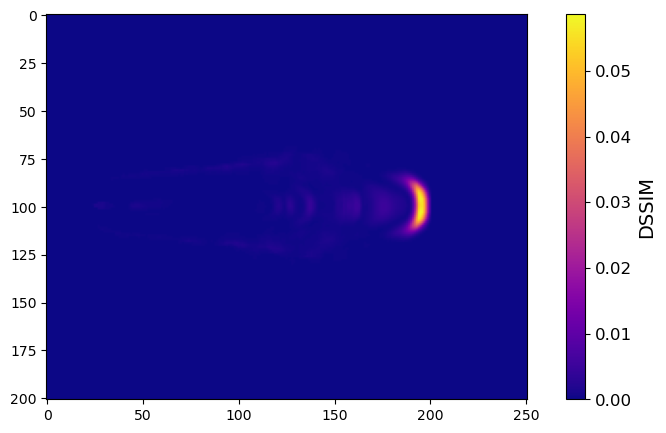

In [34]:
ground_truths_masked = np.where(test_Y < THRESHOLD, 0.0, test_Y)
predictions_mean_masked = np.where(mean_original < THRESHOLD, 0.0, mean_original)
gts, gt_mean, gt_std = _reconstruct_output_image(ground_truths_masked, rows, cols, valid_cols)
preds, pred_mean, pred_std = _reconstruct_output_image(predictions_mean_masked, rows, cols, valid_cols)
ssim_scores = per_run_ssim(gts, preds)
ssim_mean, ssim_mean_map = mean_behavior_ssim(gt_mean, pred_mean)
dssim_map = (1 - ssim_mean_map) / 2
#dssim_mean_map_mask = np.ma.masked_where(dssim_map <= 1e-10, dssim_map, copy=True)

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(dssim_map, cmap='plasma')
cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, fraction=0.05)
cbar.set_label('DSSIM', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.show()

In [35]:
ground_truths_original = np.where(test_Y < THRESHOLD, 0, test_Y)
predictions_mean = np.where(mean_original < THRESHOLD, 0, mean_original)
predictions_lower = np.where(mean_original < THRESHOLD, 0, lower_CI)
predictions_upper = np.where(mean_original < THRESHOLD, 0, upper_CI)
predictions_std = np.where(mean_original < THRESHOLD, 0, std_original)

rmse = ErrorMetrics.RMSE(predictions=predictions_mean, observations=ground_truths_original)
coverage_prob = ErrorMetrics.CoverageProbability(predictions_mean, 
                                                        predictions_lower, 
                                                        predictions_upper,
                                                        ground_truths_original)
quantile_coverage_error = ErrorMetrics.QuantileCoverageError(predictions_lower, 
                                                             predictions_upper,
                                                             ground_truths_original)


pca_bigp_results = {
    "prediction_mean": predictions_mean,
    "prediction_std": predictions_std,
    "training_time": training_time,
    "infer_time": infer_time,
    "rmse": rmse,
    "coverage_prob": coverage_prob,
    "quantile_coverage_error": quantile_coverage_error,
    "dssim": (1 - np.mean(ssim_scores)) / 2
}

print(f"Training time: {training_time:.3f} s")
print(f"Inference time: {infer_time:.3f} s")
print(f'RMSE: {rmse: .3f}')
print(f'95% confidence interval coverage probability: {coverage_prob: .3f}')
print(f'Quantile coverage error: {quantile_coverage_error: .3f}')
print(f'DSSIM: {pca_bigp_results["dssim"]: .3f}')

Training time: 26.032 s
Inference time: 0.138 s
RMSE:  0.158
95% confidence interval coverage probability:  0.991
Quantile coverage error:  0.041
DSSIM:  0.001


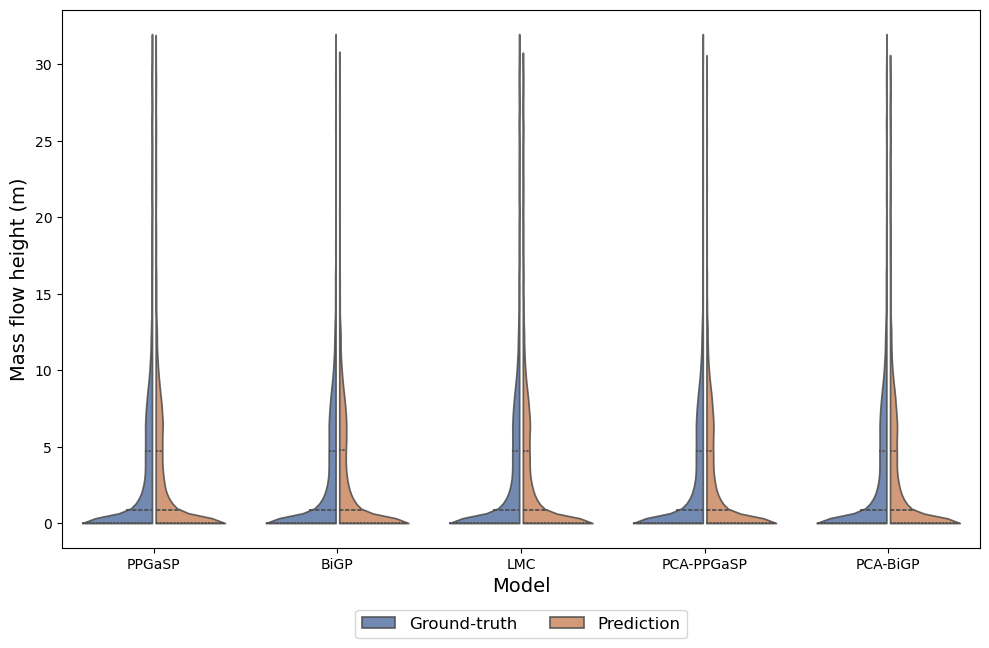

In [36]:
rows = []
gt = np.ravel(ground_truths_original)

model_prediction_pairs = [
    ("PPGaSP",  np.ravel(ppgasp_results["prediction_mean"])),
    ("BiGP",    np.ravel(bigp_results["prediction_mean"])),
    ("LMC",     np.ravel(lmc_results["prediction_mean"])),
    ("PCA-PPGaSP", np.ravel(pca_ppgasp_results["prediction_mean"])),
    ("PCA-BiGP",   np.ravel(pca_bigp_results["prediction_mean"])),
]

for model, pred in model_prediction_pairs:
    rows.append(pd.DataFrame({"Model": model, "Flow height": "Ground-truth", "Value": gt}))
    rows.append(pd.DataFrame({"Model": model, "Flow height": "Prediction",   "Value": pred}))

df_split = pd.concat(rows, ignore_index=True)

# Split violins: each model shows GT (left) vs Prediction (right)
fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("muted", n_colors=len(model_prediction_pairs))

sns.violinplot(
    data=df_split, x="Model", y="Value", hue="Flow height",
    split=True, inner="quart", cut=0, density_norm="area", gap=.05, 
    palette=["#4C72B0", "#DD8452"],  alpha=0.85
)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("Mass flow height (m)", fontsize=14)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, ncol=5, fontsize=12)
fig.tight_layout()
plt.show()

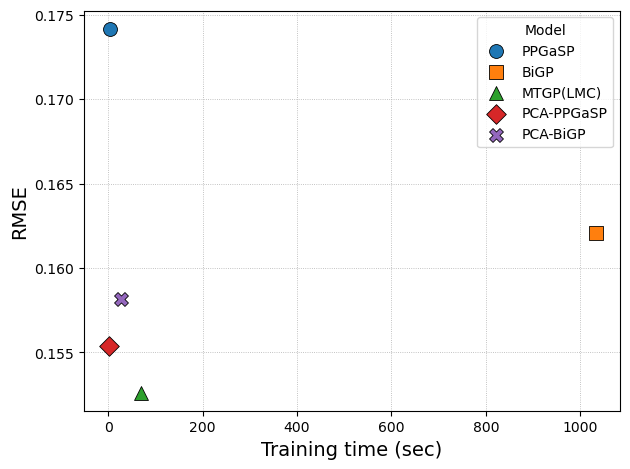

In [37]:
model_rmse_runtime_pairs = [
    ("PPGaSP", ppgasp_results["rmse"], ppgasp_results["training_time"]),
    ("BiGP", bigp_results["rmse"], bigp_results["training_time"]),
    ("MTGP(LMC)", lmc_results["rmse"], lmc_results["training_time"]),
    ("PCA-PPGaSP",  pca_ppgasp_results["rmse"], pca_ppgasp_results["training_time"]),
    ("PCA-BiGP", pca_bigp_results["rmse"], pca_bigp_results["training_time"]),
]
plt.figure()
tab10 = plt.get_cmap("tab10").colors
markers = ["o", "s", "^", "D", "X", "v", "*", "P"]
for i, pair in enumerate(model_rmse_runtime_pairs):
    model_name, rmse, train_time = pair
    color = tab10[i % len(tab10)]
    marker = markers[i % len(markers)]
    plt.scatter(train_time, rmse, color=color, marker=marker, s=100, label=model_name, edgecolors="black", linewidths=0.6, zorder=3)
plt.xlabel("Training time (sec)", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.grid(True, linestyle=":", linewidth=0.6, zorder=0)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

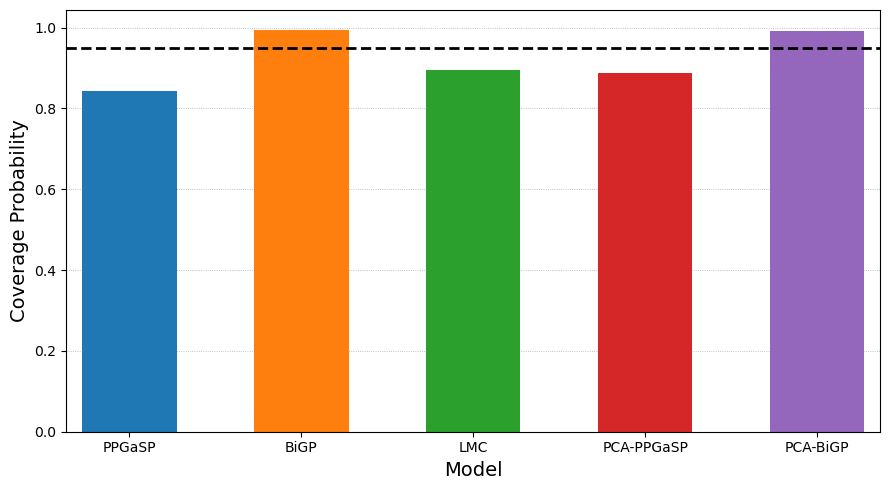

In [38]:
model_names = ["PPGaSP", "BiGP", "LMC", "PCA-PPGaSP", "PCA-BiGP"]
coverage_probs = [ppgasp_results["coverage_prob"], 
                  bigp_results["coverage_prob"], 
                  lmc_results["coverage_prob"], 
                  pca_ppgasp_results["coverage_prob"], 
                  pca_bigp_results["coverage_prob"]]
x = np.arange(len(model_names))
width = 0.55
tab10 = plt.get_cmap("tab10").colors
bar_colors = [tab10[i % len(tab10)] for i in range(len(model_names))]
fig, ax = plt.subplots(figsize=(9,5))
ax.bar(x, coverage_probs, width=width, color=bar_colors, zorder=2)
ax.axhline(0.95, color="black", linestyle="--", linewidth=2)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_xlabel("Model", fontsize=14)
ax.set_ylabel("Coverage Probability", fontsize=14)
ax.grid(axis="y", linestyle=":", linewidth=0.6, zorder=0)
ax.margins(x=0.02)
fig.tight_layout()
plt.show()

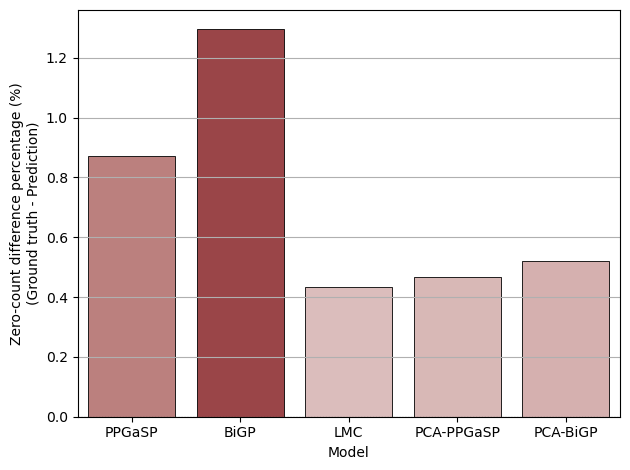

In [51]:
ground_truth = np.where(ground_truths_original < THRESHOLD, 0, ground_truths_original)
zero_counts_gt = np.count_nonzero(ground_truth == 0)
prediction_arrs = [ppgasp_results["prediction_mean"], 
                bigp_results["prediction_mean"], 
                lmc_results["prediction_mean"], 
                pca_ppgasp_results["prediction_mean"], 
                pca_bigp_results["prediction_mean"]]
zero_counts_preds = [np.count_nonzero(arr == 0) for arr in prediction_arrs]
zero_counts_diff = [(zero_counts_gt - zero_counts_preds[i]) / zero_counts_gt * 100 for i in range(len(zero_counts_preds))]
df_zero_counts = pd.DataFrame({"Model": model_names, "Zero_Counts_Diff": zero_counts_diff})
vals = df_zero_counts["Zero_Counts_Diff"].to_numpy()
cmap = sns.color_palette("vlag", as_cmap=True)
vmin = vals.min() if vals.min() < 0 else -vals.max()
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vals.max())
bar_colors = [cmap(norm(v)) for v in vals]
plt.figure()
sns.barplot(x="Model", y="Zero_Counts_Diff", data=df_zero_counts, hue="Model", palette=bar_colors, edgecolor="black", linewidth=0.6, legend=False)
plt.axhline(0, color="black", linewidth=0.8, linestyle=":")
plt.ylabel("Zero-count difference percentage (%)\n(Ground truth - Prediction)")
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.show()